# Quantum Circuit Born Machine

Yao is designed with variational quantum circuits in mind, and this tutorial
will introduce how to use Yao for this kind of task by implementing a quantum
circuit born machine described in [Jin-Guo Liu, Lei Wang (2018)](https://arxiv.org/abs/1804.04168)

let's use the package first

In [30]:
using Yao, LinearAlgebra
using Plots
pyplot()

Plots.PyPlotBackend()

## Training Target

In this tutorial, we will ask the variational circuit to learn the most basic
distribution: a guassian distribution. It is defined as follows:

$$
f(x \left| \mu, \sigma^2\right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

We implement it as `gaussian_pdf`:

In [31]:
function gaussian_pdf(x, μ::Real, σ::Real)
    pl = @. 1 / sqrt(2pi * σ^2) * exp(-(x - μ)^2 / (2 * σ^2))
    pl / sum(pl)
end
pg = gaussian_pdf(1:1<<6, 1<<5-0.5, 1<<4);

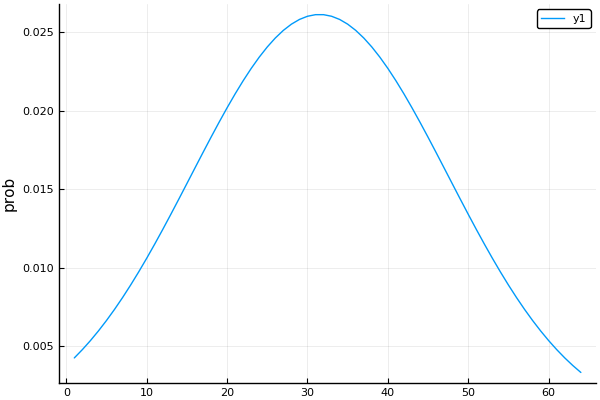

In [32]:
plot(1:1<<6, pg, ylabel="prob")

## Create the Circuit

A quantum circuit born machine looks like the following:

![differentiable ciruit](images/differentiable.png)

It is composited by two different layers: **rotation layer** and **entangler layer**.

## Rotation Layer

Arbitrary rotation is built with **Rotation Gate** on **Z, X, Z** axis
with parameters.

$$
Rz(\theta) \cdot Rx(\theta) \cdot Rz(\theta)
$$

Since our input will be a $|0\dots 0\rangle$ state.
The first layer of arbitrary rotation can just
use $Rx(\theta) \cdot Rz(\theta)$ and the last
layer of arbitrary rotation could just
use $Rz(\theta)\cdot Rx(\theta)$

In **幺**, every Hilbert operator is a **block** type, this
ncludes all **quantum gates** and **quantum oracles**.
In general, operators appears in a quantum circuit
can be divided into **Composite Blocks** and **Primitive Blocks**.

We follow the low abstraction principle and
thus each block represents a certain approach
of calculation. The simplest **Composite Block**
is a **Chain Block**, which chains other blocks
(oracles) with the same number of qubits together.
It is just a simple mathematical composition of
operators with same size. e.g.


$$
\text{chain(X, Y, Z)} \iff X \cdot Y \cdot Z
$$

We can construct an arbitrary rotation block by chain ``Rz``, ``Rx``, ``Rz`` together.

In [33]:
chain(Rz(0.0), Rx(0.0), Rz(0.0))

nqubits: 1, datatype: Complex{Float64}
chain
├─ rot(Z gate, 0.0)
├─ rot(X gate, 0.0)
└─ rot(Z gate, 0.0)

[`Rx`](@ref), [`Rz`](@ref) will construct new rotation gate,
which are just shorthands for `rot(X, 0.0)`, etc.

Then let's chain them up

In [34]:
layer(nbit::Int, x::Symbol) = layer(nbit, Val(x))
layer(nbit::Int, ::Val{:first}) = chain(nbit, put(i=>chain(Rx(0), Rz(0))) for i = 1:nbit);

We do not need to feed the first `n` parameter into `put` here.
All factory methods can be **lazy** evaluate **the first arguements**, which is the number of qubits.
It will return a lambda function that requires a single interger input.
The instance of desired block will only be constructed until all the information is filled.
When you filled all the information in somewhere of the declaration, 幺 will be able to infer the others.
We will now define the rest of rotation layers

In [35]:
layer(nbit::Int, ::Val{:last}) = chain(nbit, put(i=>chain(Rz(0), Rx(0))) for i = 1:nbit)
layer(nbit::Int, ::Val{:mid}) = chain(nbit, put(i=>chain(Rz(0), Rx(0), Rz(0))) for i = 1:nbit);

## Entangler

Another component of quantum circuit born machine are
several **CNOT** operators applied on different qubits.

In [36]:
entangler(pairs) = chain(control(ctrl, target=>X) for (ctrl, target) in pairs);

We can then define such a born machine

In [37]:
function build_circuit(n, nlayers, pairs)
    circuit = chain(n)
    push!(circuit, layer(n, :first))
    for i in 2:nlayers
        push!(circuit, cache(entangler(pairs)))
        push!(circuit, layer(n, :mid))
    end
    push!(circuit, cache(entangler(pairs)))
    push!(circuit, layer(n, :last))
    return circuit
end

build_circuit (generic function with 1 method)

We use the method `cache` here to tag the entangler block that it
should be cached after its first run, because it is actually a
constant oracle. Let's see what will be constructed

In [38]:
build_circuit(4, 1, [1=>2, 2=>3, 3=>4])

nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (2)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (3)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ put on (4)
│     └─ chain
│        ├─ rot(X gate, 0.0)
│        └─ rot(Z gate, 0.0)
├─ [cached] chain
│     ├─ control(1)
│     │  └─ (2,) X gate
│     ├─ control(2)
│     │  └─ (3,) X gate
│     └─ control(3)
│        └─ (4,) X gate
└─ chain
   ├─ put on (1)
   │  └─ chain
   │     ├─ rot(Z gate, 0.0)
   │     └─ rot(X gate, 0.0)
   ├─ put on (2)
   │  └─ chain
   │     ├─ rot(Z gate, 0.0)
   │     └─ rot(X gate, 0.0)
   ├─ put on (3)
   │  └─ chain
   │     ├─ rot(Z gate, 0.0)
   │     └─ rot(X gate, 0.0)
   └─ put on (4)
      └─ chain
         ├─ rot(Z gate, 0.0)
         └─ rot(X gate, 0.0)


## MMD Loss & Gradients

The MMD loss is describe below:
$$
\begin{aligned}
\mathcal{L} &= \left| \sum_{x} p \theta(x) \phi(x) - \sum_{x} \pi(x) \phi(x) \right|^2\\
            &= \langle K(x, y) \rangle_{x \sim p_{\theta}, y\sim p_{\theta}} - 2 \langle K(x, y) \rangle_{x\sim p_{\theta}, y\sim \pi} + \langle K(x, y) \rangle_{x\sim\pi, y\sim\pi}
\end{aligned}
$$


We will use a squared exponential kernel here.

In [39]:
struct RBFKernel
    σ::Float64
    m::Matrix{Float64}
end

function RBFKernel(σ::Float64, space)
    dx2 = (space .- space').^2
    return RBFKernel(σ, exp.(-1/2σ * dx2))
end

kexpect(κ::RBFKernel, x, y) = x' * κ.m * y

kexpect (generic function with 1 method)

There are two different way to define the loss:

In simulation we can use the probability distribution of the state directly

In [40]:
get_prob(qcbm) = probs(zero_state(nqubits(qcbm)) |> qcbm)

function loss(κ, c, target)
    p = get_prob(c) - target
    return kexpect(κ, p, p)
end

loss (generic function with 1 method)

Or if you want to simulate the whole process with measurement (which is entirely
physical), you should define the loss with measurement results, for convenience
we directly use the simulated results as our loss

### Gradients
the gradient of MMD loss is

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \theta^i_l} &= \langle K(x, y) \rangle_{x\sim p_{\theta^+}, y\sim p_{\theta}} - \langle K(x, y) \rangle_{x\sim p_{\theta}^-, y\sim p_{\theta}}\\
&- \langle K(x, y) \rangle _{x\sim p_{\theta^+}, y\sim\pi} + \langle K(x, y) \rangle_{x\sim p_{\theta^-}, y\sim\pi}
\end{aligned}
$$

which can be implemented as

In [41]:
function gradient(qcbm, κ, ptrain)
    n = nqubits(qcbm)
    prob = get_prob(qcbm)
    grad = zeros(Float64, nparameters(qcbm))

    count = 1
    for k in 1:2:length(qcbm), each_line in qcbm[k], gate in content(each_line)
        dispatch!(+, gate, π/2)
        prob_pos = probs(zero_state(n) |> qcbm)

        dispatch!(-, gate, π)
        prob_neg = probs(zero_state(n) |> qcbm)

        dispatch!(+, gate, π/2) # set back

        grad_pos = kexpect(κ, prob, prob_pos) - kexpect(κ, prob, prob_neg)
        grad_neg = kexpect(κ, ptrain, prob_pos) - kexpect(κ, ptrain, prob_neg)
        grad[count] = grad_pos - grad_neg
        count += 1
    end
    return grad
end

gradient (generic function with 1 method)

Now let's setup the training

In [42]:
using Flux.Optimise
qcbm = build_circuit(6, 10, [1=>2, 3=>4, 5=>6, 2=>3, 4=>5, 6=>1])
dispatch!(qcbm, :random) # initialize the parameters

κ = RBFKernel(0.25, 0:2^6-1)
pg = gaussian_pdf(1:1<<6, 1<<5-0.5, 1<<4);
opt = ADAM()

function train(qcbm, κ, opt, target)
    history = Float64[]
    for _ in 1:100
        push!(history, loss(κ, qcbm, target))
        ps = parameters(qcbm)
        Optimise.update!(opt, ps, gradient(qcbm, κ, target))
        popdispatch!(qcbm, ps)
    end
    return history
end

history = train(qcbm, κ, opt, pg)
trained_pg = probs(zero_state(nqubits(qcbm)) |> qcbm)

64-element Array{Float64,1}:
 0.004949796033194015 
 0.008610452538485582 
 0.004306470020658978 
 0.007612462243589652 
 0.00703871374806971  
 0.01022684746639653  
 0.005020982471676006 
 0.008275845132628135 
 0.011551680615306367 
 0.009241203376824835 
 0.007271743580633538 
 0.014097516828957437 
 0.016060555095142693 
 ⋮                    
 0.012189392112723994 
 0.011788883954540651 
 0.005573432794460104 
 0.01400420812013604  
 0.0034933802748169504
 0.008303658194569132 
 0.00651435766826844  
 0.0061301956626380666
 0.006836520752272872 
 0.009192425196840234 
 0.0016167091926223784
 0.008330754662834103 

And we have the history of training which is

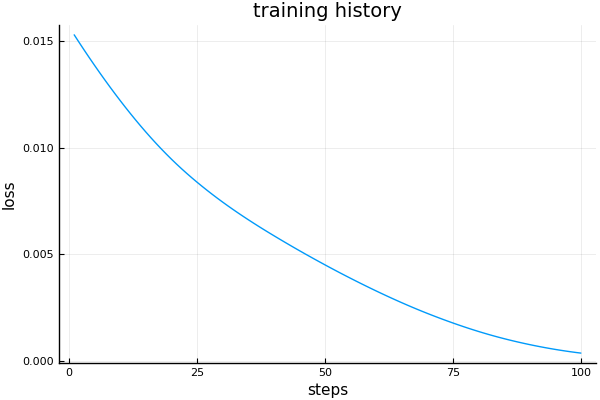

In [43]:
fig1 = plot(history; legend=nothing)
title!("training history")
xlabel!("steps"); ylabel!("loss")

![](../assets/figures/history.png)

And let's check what we got

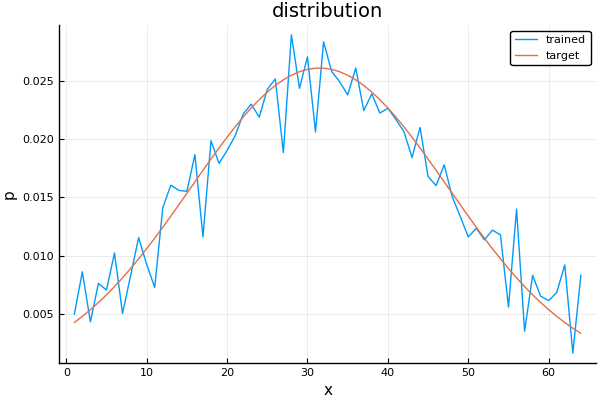

In [44]:
fig2 = plot(1:1<<6, trained_pg; label="trained")
plot!(fig2, 1:1<<6, pg; label="target")
title!("distribution")
xlabel!("x"); ylabel!("p")

![](../assets/figures/distribution.png)

So within 50 steps, we got a pretty close estimation of our
target distribution!